# Retesting Julia's method for Panan005

In [1]:
import dask.distributed as dsk
import glob
import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34861/status,
Dashboard: /proxy/34861/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40699,Workers: 28
Dashboard: /proxy/34861/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:37625,Total threads: 1
Dashboard: /proxy/42989/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:37703,


In [4]:
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/outpu*/*.ocean_month_z.nc'))[-120:]
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/outpu*/*.ocean_month_z.nc'))[:60]

In [5]:
shelf_mask = shelf_mask = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc')['contour_masked_above']

In [6]:
areaC = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])
areaM = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/output120/20010101.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])

In [7]:
def preprocess(ds):
    ds = ds[['thetao', 'volcello']].sel(yh=shelf_mask['yh'], z_l=slice(None,500))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
tempC = cont['thetao']
volcC = cont['volcello']
thikC = cont['volcello']/areaC

In [9]:
tempM = melt['thetao']
volcM = melt['volcello']
thikM = melt['volcello']/areaM

In [10]:
temp_500_C = tempC.weighted(thikC.fillna(0)).mean('z_l').where(shelf_mask == 0).weighted(areaC.fillna(0)).mean(['xh', 'yh'])
temp_500_M = tempM.weighted(thikM.fillna(0)).mean('z_l').where(shelf_mask == 0).weighted(areaM.fillna(0)).mean(['xh', 'yh'])

In [13]:
temp_500_C = temp_500_C.load()

In [14]:
temp_500_M = temp_500_M.load()

Text(0.5, 1.0, 'Panan005 Time Series of Temperature for shelf top 500m')

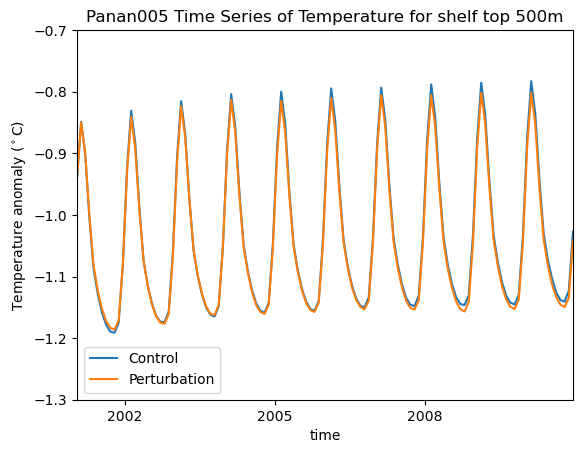

In [34]:
temp_500_C.plot(label="Control")
temp_500_M.plot(label="Perturbation")
plt.xlim(380,4000)
plt.ylim(-1.30,-0.70)
plt.ylabel("Temperature anomaly ($^\circ$C)")
plt.legend(loc="lower left")
plt.title("Panan005 Time Series of Temperature for shelf top 500m")

## Mapping

In [18]:
tempcont_500 = tempC.sel(z_l=slice(0,500)).weighted(thikC['z_l'].fillna(0)).mean(dim='z_l').mean(dim='time')
temppert_500 = tempM.sel(z_l=slice(0,500)).weighted(thikM['z_l'].fillna(0)).mean(dim='z_l').mean(dim='time')
tempanom_500 = temppert_500 - tempcont_500

In [19]:
tempanom_500 = tempanom_500.load()

In [23]:
import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

In [24]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
projection = ccrs.SouthPolarStereo()

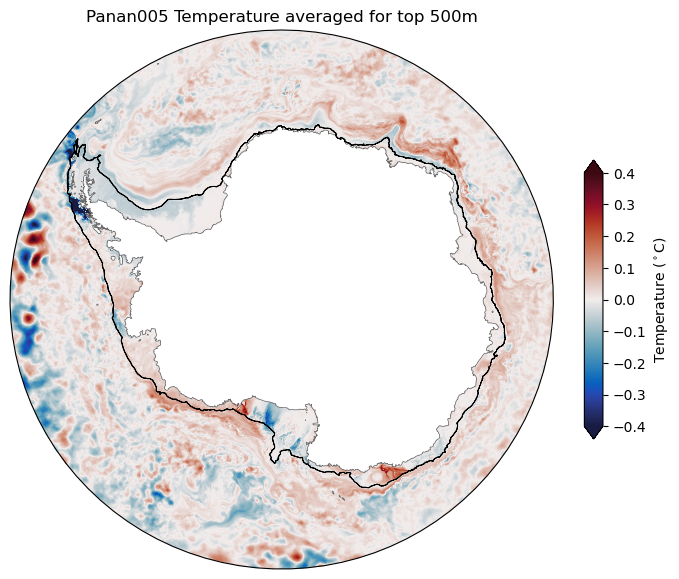

In [27]:
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

tempanom_500.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.4,
    vmax=0.4,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Temperature ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Panan005 Temperature averaged for top 500m");

## Saving

In [36]:
# Note this was done wrong but has since been corrected.
temp_500_C.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan005_temp_C_500time.nc')
temp_500_M.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan005_temp_M_500time.nc')